# Pianist classification using melodic and rhythmic features

## Import dependencies and set constants, etc.

In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src import utils
from src.detect.midi_utils import *
from src.features.melody_features import *
from src.features.rhythm_features import *

In [2]:
smallest_n_gram = 3
largest_n_gram = 10

## Pre-processing

In [3]:
# Get filepaths for processing
root = f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v01/corpus_chronology'
files = [os.path.join(root, f) for f in os.listdir(root)]

In [4]:
# Load in onsets and beats for each track
oms = [utils.load_track_from_files(f) for f in files]

/home/huwcheston/PycharmProjects/Cambridge-Jazz-Trio-Database/src/utils.py:710: UserWarning: genfromtxt: Empty input file: "/home/huwcheston/PycharmProjects/Cambridge-Jazz-Trio-Database/data/cambridge-jazz-trio-database-v01/corpus_chronology/petersono-honeydripper-brownrthigpene-1962-b498d90e/bass.csv"
  om.ons[instr] = np.genfromtxt(rf'{trackpath}/{instr}.csv', delimiter=',')
/home/huwcheston/PycharmProjects/Cambridge-Jazz-Trio-Database/src/utils.py:710: UserWarning: genfromtxt: Empty input file: "/home/huwcheston/PycharmProjects/Cambridge-Jazz-Trio-Database/data/cambridge-jazz-trio-database-v01/corpus_chronology/evansb-allofyou-gomezezigmunde-1976-acbb08b7/bass.csv"
  om.ons[instr] = np.genfromtxt(rf'{trackpath}/{instr}.csv', delimiter=',')
/home/huwcheston/PycharmProjects/Cambridge-Jazz-Trio-Database/src/utils.py:710: UserWarning: genfromtxt: Empty input file: "/home/huwcheston/PycharmProjects/Cambridge-Jazz-Trio-Database/data/cambridge-jazz-trio-database-v01/corpus_chronology/mance

In [5]:
# Extract melody for each track
mms = [MelodyMaker(os.path.join(fp, 'piano_midi.mid'), om) for fp, om in zip(files, oms)]

## Create histogram of pitch classes for one track

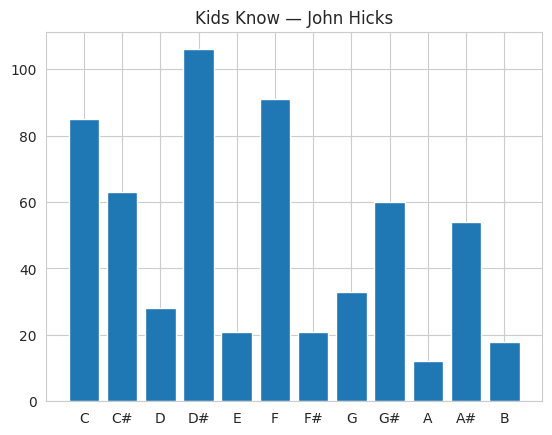

In [7]:
# Create a histogram for the pitch classes in one track
# Extract the melody for our first track
mel = list(mms[105].extract_melody())
# Count the pitch classes
pitch_classes = Counter([m.note for m in mel])
# Sort the pitch classes in order of the piano keys
sorted_pitches = {i: pitch_classes[i] for i in utils.ALL_PITCHES}
# Create the bar chart
plt.bar(sorted_pitches.keys(), sorted_pitches.values())
plt.title(oms[105].item['track_name'] + ' — ' + oms[105].item['pianist'])
plt.show()

## Visualise tonalness across all chunks

In [ ]:
tonalness = []
for melody, onsets in zip(mms, oms):
    mel = list(melody.extract_melody())
    for chunk in melody.chunk_melody(mel):
        if len(chunk) < 2:
            continue
        ton = TonalityExtractor(chunk)
        tonalness.append(dict(**onsets.item, **ton.summary_dict))

In [ ]:
ton_df = pd.DataFrame(tonalness)

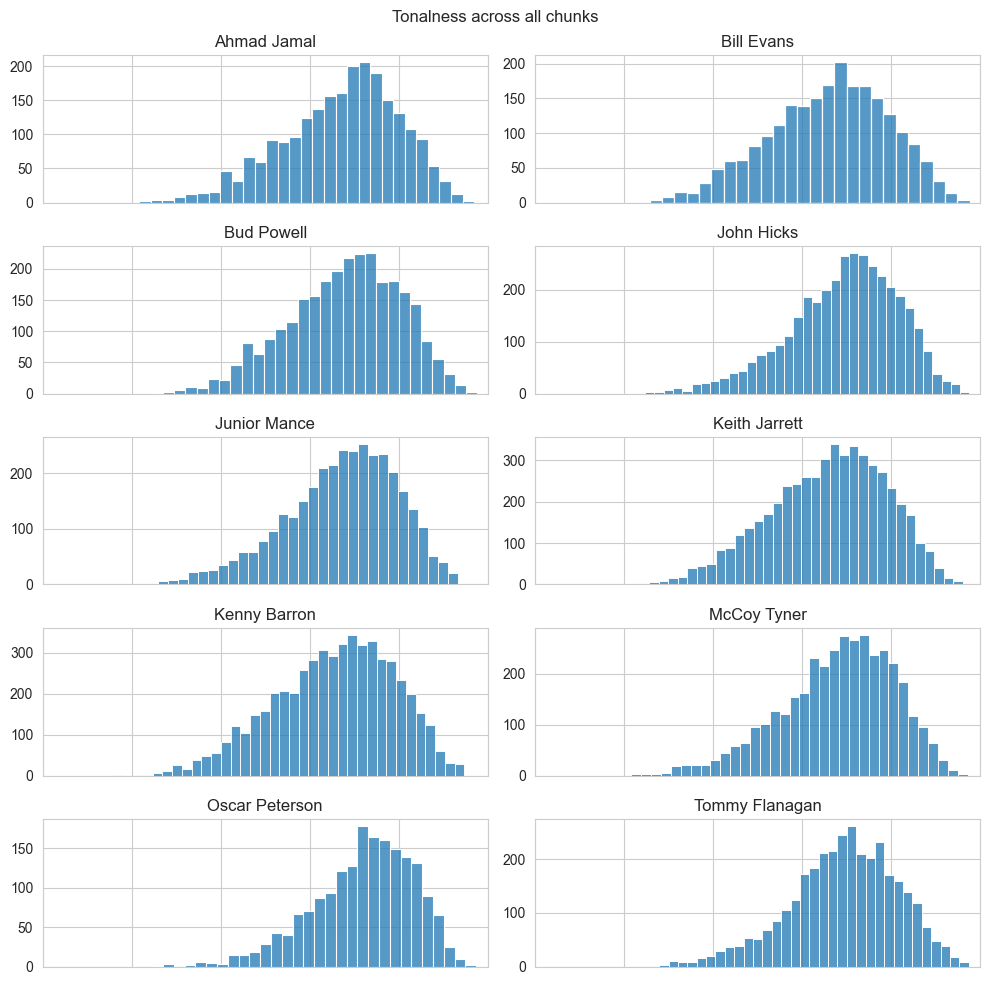

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for a, (idx, grp) in zip(ax.flatten(), ton_df.groupby('pianist')):
    sns.histplot(grp['tonalness'], ax=a)
    a.set(title=idx, xlim=(0, 1), ylabel='', xlabel='', xticklabels=[])
plt.suptitle('Tonalness across all chunks')
plt.tight_layout()
plt.show()

## N-gram extraction

### Extract n-grams which appear in more than 3 solos

In [6]:
res = {}
for melody, onsets in tqdm(zip(mms, oms)):
    mel = list(melody.extract_melody())
    sequence = list(melody.extract_intervals(mel))
    if len(sequence) < 2:
        continue
    for start in range(len(sequence)):
        for n in range(smallest_n_gram, largest_n_gram + 1):
            n_gram = tuple([i.interval for i in sequence[start: start + n]])
            if len(n_gram) == n:
                if str(n_gram) not in res.keys():
                    res[str(n_gram)] = {
                        'tracks': set(),
                        'pianists': set(),
                        'uses': 0,
                        'n': len(n_gram)
                    } 
                res[str(n_gram)]['tracks'].add(onsets.item['mbz_id'])
                res[str(n_gram)]['pianists'].add(onsets.item['pianist'])
                res[str(n_gram)]['uses'] += 1

0it [00:00, ?it/s]

In [7]:
valid_ngrams = set(ng for ng, vals in res.items() if len(vals['tracks']) >= 3)

### Create audio extract for most played 5-gram

In [8]:
desired_n = 5
most_played_count = max(vals['uses'] for vals in res.values() if vals['n'] == desired_n)
most_played_ngram = [ng for ng, vals in res.items() if vals['uses'] == most_played_count and vals['n'] == desired_n][0]

In [88]:
import librosa

big_audio = []
for melody, onsets in tqdm(zip(mms, oms)):
    mel = list(melody.extract_melody())
    sequence = list(melody.extract_intervals(mel))
    if len(sequence) < 2:
        continue
    timestamps = []
    for start in range(len(sequence)):
        n_gram = tuple([i.interval for i in sequence[start: start + desired_n]])
        if len(n_gram) == desired_n and str(n_gram) == most_played_ngram:
            ts_start, ts_end = sequence[start].start, sequence[start + desired_n].start
            timestamps.append((ts_start, ts_end))
    if len(timestamps) == 0:
        continue
    audio, _ = librosa.load(f'{utils.get_project_root()}/data/raw/audio/{onsets.item["fname"]}.{utils.AUDIO_FILE_FMT}', sr=utils.SAMPLE_RATE, mono=True)
    for start, end in timestamps:
        start_aud = int(utils.SAMPLE_RATE * start)
        end_aud = int(utils.SAMPLE_RATE * end)
        audio_cut = audio[start_aud: end_aud]
        audio_pad = np.concatenate((audio_cut, np.zeros(utils.SAMPLE_RATE // 2)))
        big_audio.append(audio_pad)

0it [00:00, ?it/s]

In [89]:
import soundfile as sf
big_conc = np.concatenate(big_audio, axis=0)
with open(f'{utils.get_project_root()}/big5.wav', 'wb') as fp:
    sf.write(fp, np.concatenate(big_audio), utils.SAMPLE_RATE)

### Extract only valid n-grams from all solos

In [8]:
ngrams = []
valid_dict = {ng: 0 for ng in valid_ngrams}
for melody, onsets in tqdm(zip(mms, oms)):
    mel = list(melody.extract_melody())
    sequence = list(melody.extract_intervals(mel))
    if len(sequence) < 2:
        continue
    track_results = {'pianist': onsets.item['pianist'], 'track_name': onsets.item['track_name'], **valid_dict}
    for start in range(len(sequence)):
        for n in range(smallest_n_gram, largest_n_gram + 1):
            n_gram = tuple([i.interval for i in sequence[start: start + n]])
            if len(n_gram) == n:
                n_gram = str(n_gram)
                if n_gram not in valid_ngrams:
                    continue
                track_results[n_gram] += 1
    ngrams.append(track_results)

0it [00:00, ?it/s]

In [11]:
tracks = pd.DataFrame(ngrams)

### Model fitting

To try:
Tree-based methods
- Random Forest
- Gradient-Boosted Trees

Classification:
- SVM
- Naive Bayes
- Multiclass logistic regression

### Random Forest

In [25]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [26]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # The criterion to use when splitting a node
    criterion=['gini', 'entropy', 'log_loss'],
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(10, 1001, 1)],
    # Max number of features considered for splitting a node
    max_features=['sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[i for i in range(1, 101, 1)],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(2, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
)

In [22]:
X = tracks.iloc[:, 2:].to_numpy()
y = tracks.iloc[:, 0].to_numpy()

In [27]:
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=rf, param_grid=test_params, cv=cv, n_jobs=-1, verbose=10, scoring=accuracy_score)

In [ ]:
gs.fit(X, y)